# Exemplo de self attention

In [2]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/studio-lab-user/.conda/envs/default/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
import torch 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# ====
# 0
# ====

# -- ENTRADA:
text = 'Quero um sorvete'
text_tokens = ['Quero', 'um', 'sorvete']

# -- IDs:
text_ids = [27,11,83] # tokens sintéticos
VOCAB = 100 # Quantidade de palavras - no BERT ~30k

# -- DIMENSÃO DOS EMBEDDINGS:
D = 8

# -- COMPRIMENTO DA SEQUÊNCIA:
L = 3

# -- NÚMERO DE CABEÇAS:
H = 2

# -- MATRIZ DE EMBEDDINGS LxD:
embs  = torch.nn.Embedding(VOCAB, D)

# tensor com zeros_like
embeddings = torch.zeros(L * D).reshape(L, D)
print(f'Shape da matriz de embeddings: {embeddings.shape}\n')

print('Matriz de embeddings\n')
for i , token in enumerate(text_ids):
    embeddings[i] = embs(torch.tensor(token))
embeddings

Shape da matriz de embeddings: torch.Size([3, 8])

Matriz de embeddings



tensor([[-1.1465,  0.7226, -0.3987, -1.8349, -0.0414,  0.2804, -1.6433,  0.2331],
        [ 0.6462,  0.0602, -0.0701, -0.0455, -0.2459, -1.4918, -0.2091, -2.2546],
        [ 0.3551, -1.1194,  1.0270,  0.6847,  0.5966, -1.1471,  0.7120, -1.0607]],
       grad_fn=<AsStridedBackward0>)

In [5]:
# ====
# 1
# ====

# -- MATRIZ DE PESOS, Q, K, V --> DxD (INICIADOS ARBITRARIAMENTE):
Qw = torch.nn.Linear(D, D)
Kw = torch.nn.Linear(D, D)
Vw = torch.nn.Linear(D, D)

print(f'Qw shape: {Qw(embeddings).shape}')
print(f'Kw shape: {Kw(embeddings).shape}')
print(f'Vw shape: {Vw(embeddings).shape}')

Qw shape: torch.Size([3, 8])
Kw shape: torch.Size([3, 8])
Vw shape: torch.Size([3, 8])


In [6]:
# ====
# 2
# ====

# -- OBTER Q, K e V:
print(f'Shape da entrada: {embeddings.size()} -- Shape das Matrizes de pesos Qw, Kw e Vw: {Qw.weight.size()}')

Q =  Qw(embeddings)
K =  Kw(embeddings)
V =  Vw(embeddings)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Shape da entrada: torch.Size([3, 8]) -- Shape das Matrizes de pesos Qw, Kw e Vw: torch.Size([8, 8])
Q torch.Size([3, 8])
K torch.Size([3, 8])
V torch.Size([3, 8])


In [7]:
# ====
# 3
# ====

dk = D//H
Q = Q.reshape(L, H, dk)
K = K.reshape(L, H, dk)
V = V.reshape(L, H, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Q torch.Size([3, 2, 4])
K torch.Size([3, 2, 4])
V torch.Size([3, 2, 4])


In [8]:
# ====
# 4
# ====

Q = Q.transpose(0,1) # (H, L, dk)
K = K.transpose(0,1) # (H, L, dk)
V = V.transpose(0,1) # (H, L, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Q torch.Size([2, 3, 4])
K torch.Size([2, 3, 4])
V torch.Size([2, 3, 4])


In [9]:
# ====
# 5
# ====

# -- CALCULAR O SCORE:    
QKT = torch.einsum('hld, hcd -> hlc', Q, K) # K.transpose(-2,-1)=(H, dk, L) := (H, L, dk)x(H, dk, L) = (H, L, L)
print('SCORE', QKT.size())

# -- DIVIDIR POR SQRT(D)

# -- SOFTMAX:
Softmax = torch.nn.Softmax(dim=-1)
Softmax = Softmax(QKT.float())
SCORE = QKT/torch.sqrt(torch.tensor(D)) # (H, L, L) 

SCORE torch.Size([2, 3, 3])


In [10]:
# ====
# 6
# ====

SV = torch.einsum('hlc, hck -> hlk', SCORE, V) # (H, L, L)x(H, L, D//H)=(H, L, D//H)
print('SV', SV.size()) 

SV torch.Size([2, 3, 4])


In [11]:
# ====
# 7
# ====

SV = SV.transpose(0,1) # (L, H, dk)
print('SV', SV.size())

SV torch.Size([3, 2, 4])


In [12]:
# ====
# 8
# ====

SV = SV.reshape(L, -1) # (L, H*dk)
print('SV', SV.size())

# -- MULTIPLICAR PELA MATRIZ DE PROJEÇÃO Wo
Wow = torch.nn.Linear(D, D)

SV torch.Size([3, 8])


In [13]:
# ====
# 9
# ====

ATT = Wow(SV) # (L, D)x(DxD)
print('ATT', ATT.size())
ATT

ATT torch.Size([3, 8])


tensor([[ 0.3308,  0.0150,  0.0054,  0.1729,  0.1888, -0.4226, -0.0555, -0.0771],
        [ 0.1703,  0.1780, -0.3654,  0.1712, -0.1720, -0.3826, -0.0529, -0.0676],
        [ 0.0985,  0.1599, -0.3937,  0.1501, -0.2126, -0.4708, -0.0764,  0.0123]],
       grad_fn=<AddmmBackward0>)

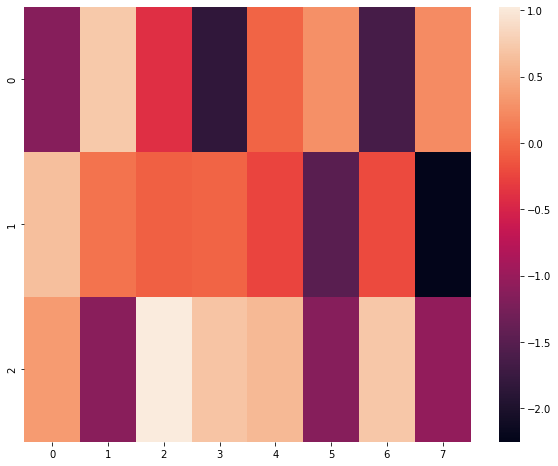

In [14]:
# Embs sem ATT
plt.figure(figsize=(10,8))
sns.heatmap(embeddings.detach().numpy())
plt.savefig('semAtt.png')

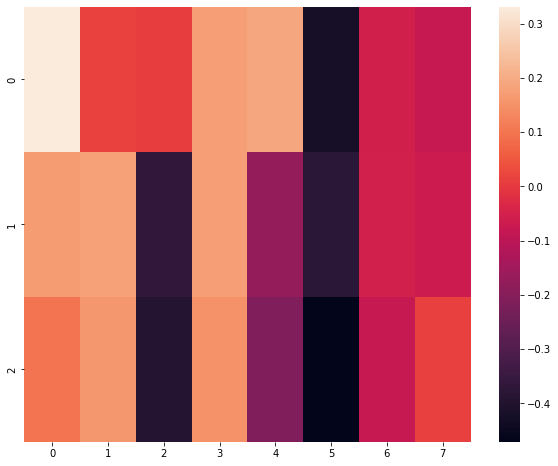

In [15]:
# ATT Embs
plt.figure(figsize=(10,8))
sns.heatmap(ATT.detach().numpy())
plt.savefig('comAtt.png')

# Fim do Notebook